# Reinforcement Learning Agent for Statistical Arbitrage

This notebook demonstrates how to configure and train a reinforcement learning agent for statistical arbitrage using a snapshot model. The agent will learn to identify and exploit statistical arbitrage opportunities in financial markets.

## Install Packages

The following libraries are required for this notebook. If you haven't installed them yet, you can do so using running the cell below or by using pip install in your terminal.

In [1]:
# Uncomment and install packages once
# %pip -q install -U numpy pandas pyarrow gdown gymnasium stable-baselines3 torch matplotlib tensorboard

## Import Libraries

In [ ]:
import os
import json
from gdown import download
import math
import random
import pytz

from datetime import datetime

from typing import Tuple, Set, Optional
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# Reinforcement Learning
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

# Deep Learning
import torch

from config import CONFIG

print("Imports complete.")

Imports complete.


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## Key Updates in This Version

This notebook has been updated to fix several critical issues:

1. **Extended Training Period**: Training now runs for 4 months (May-August 2024) with 50,000 timesteps instead of 15 days with 1,000 timesteps

2. **Fixed Tensor-Time Alignment**: The slicing function now properly tracks timestamps for each sample, ensuring correct train/val splits

3. **Fixed Feature Indexing**: Corrected the bug where feature indices didn't align with actual column positions in the data

4. **Continuous Action Space**: The action space is now continuous from -1 to 1:
   - **Action = -1**: Maximum short first asset / long second asset
   - **Action = 0**: Close all positions (100% cash)
   - **Action = 1**: Maximum long first asset / short second asset
   - **Action = any value in between**: Proportional position sizing

5. **Proper Pair Trading**: Both legs of the pair are now used in portfolio calculations

6. **Better Error Handling**: Added validation for required features and data quality checks

7. **Action Tracking**: Added visualization of trading actions over time

## Helper Functions

In [4]:
# set annualization factors for different timeframes
ANNUALIZATION = {"1m":365*24*60,
                 "5m":365*24*12,
                 "15m":365*24*4,
                 "1h":365*24,
                 "1d":365}

# create directory if it doesn't already exist
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

## Set Computation Device

This section sets the computation device for training the model. It checks if a GPU is available and sets it as the device; otherwise, it defaults to CPU.

In [5]:
# run on cuda GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")

# run on Apple Silicon GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using Apple Silicon GPU.")

# run on CPU (slow)
else:
    device = torch.device("cpu")
    print("CUDA and MPS are not available. Using CPU.")

MPS is available. Using Apple Silicon GPU.


## Set Seeds

This section sets the random seeds for various libraries to ensure that the results are reproducible.

Note: It is good practice to type (set data types) for function and method parameters for better code maintainability.

In [6]:
def set_all_seeds(seed: int = 42):
    random.seed(seed) # seed for random module
    np.random.seed(seed) # seed for numpy module
    try:
        torch.manual_seed(seed) # seed for torch module
        if torch.cuda.is_available(): # seed for CUDA device
            torch.cuda.manual_seed_all(seed)
        elif torch.backends.mps.is_available(): # seed for Apple Silicon device
            torch.backends.mps.manual_seed_all(seed)
    except Exception:
        pass

set_all_seeds(CONFIG["ENV"]["seed"]) # set all seeds for reproducibility

## Download Feature Data

In this section, we retrieve the .csv file created during feature engineering.

In [7]:
def download_file(file_name: str, file_id: str, out_dir: str):
    ensure_dir(out_dir)

    out_path = os.path.join(out_dir, f"{file_name}.csv")  # full output path

    if os.path.exists(out_path):
        print(f"Skipping download. File {file_name} already exists in cache.")
        return

    try:
        print(f"Downloading {file_name} -> {out_path}")
        url = f"https://drive.google.com/uc?id={file_id}"
        success = download(url, out_path, quiet=False, use_cookies=False, verify=True)
        print("Download complete.")
        return success
    except Exception as e:
        print(f"Download attempt failed for {file_name}. Error: {str(e)}")
    
# donwload features
file_name = CONFIG["DATA"]["features"]["file_name"]
file_id = CONFIG["DATA"]["features"]["file_id"]
cache_dir = CONFIG["DATA"]["cache_dir"]

success = download_file(file_name, file_id, cache_dir)

Skipping download. File bin_futures_full_features already exists in cache.


## Load Feature Data

Once the data is downloaded, this section loads the data into a pandas DataFrame for later processing.

In [8]:
def load_csv_to_df(
    path: str,
    sep: str = ",",
    timestamp_index_col: str | None = "datetime",
    encoding: str = "utf-8-sig",
    **read_csv_kwargs,
) -> pd.DataFrame:
    """
    Load a CSV into a pandas DataFrame.

    Parameters
    ----------
    path : str
        Filesystem path to the CSV.
    parse_timestamp_col : str | None
        If provided and present in the CSV, this column will be parsed to datetime.
        Set to None to skip datetime parsing.
    **read_csv_kwargs :
        Extra arguments passed to `pd.read_csv` (e.g., sep, dtype, usecols).

    Returns
    -------
    pd.DataFrame
    """

    # Parse header-only to check for timestamp col presence
    head = pd.read_csv(path, sep=sep, encoding=encoding, nrows=0)
    if timestamp_index_col and timestamp_index_col in head.columns:
        read_csv_kwargs = {
            **read_csv_kwargs,
            "parse_dates": [timestamp_index_col],
        }

    df = pd.read_csv(path, sep=sep, encoding=encoding, engine="pyarrow", **read_csv_kwargs)

    df = df.set_index("datetime")

    return df


# load features
file_name = CONFIG["DATA"]["features"]["file_name"]
cache_dir = CONFIG["DATA"]["cache_dir"]
index = CONFIG["DATA"]["features"]["index"]
sep = CONFIG["DATA"]["features"].get("seperator", ",")
file_path = os.path.join(cache_dir, f"{file_name}.csv")
features_df = load_csv_to_df(file_path, sep, timestamp_index_col=index)

# print dataframe info
print("Features DataFrame Info:")
print(features_df.info())

Features DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2024-05-01 00:00:00 to 2025-04-30 23:59:00
Columns: 789 entries, AAVE_close to XRP_fundingMinutesLeft
dtypes: float64(763), int64(25), object(1)
memory usage: 3.1+ GB
None


## Identify Feature Structure

In [9]:
def identify_assets_features_pairs(
    df: pd.DataFrame,
    single_asset_format: str,
    pair_feature_format: str,
) -> tuple[list[str], list[str], list[str], list[tuple[str, str]]]:
    """
    Returns distinct
      1. assets
      2. single-asset feature names (ARB_closeUpperShadow → closeUpperShadow)
      3. pair feature names (ARB_ETH_spreadNorm → spreadNorm)
      4. unordered asset pairs
    """

    def format_to_regex(fmt: str) -> re.Pattern:
        escaped = re.escape(fmt)

        def repl(match: re.Match[str]) -> str:
            name = match.group(1)
            char_class = r"[A-Za-z0-9_]+" if "FEATURE" in name.upper() else r"[A-Za-z0-9]+"
            return f"(?P<{name}>{char_class})"

        escaped = re.sub(r"\\\{(\w+)\\\}", repl, escaped)
        return re.compile(f"^{escaped}$")

    single_asset_pattern = format_to_regex(single_asset_format)
    pair_feature_pattern = format_to_regex(pair_feature_format)
    generic_single_pattern = re.compile(r"^(?P<ASSET>[A-Za-z0-9]+)_(?P<FEATURE>[A-Za-z0-9_]+)$")

    assets: Set[str] = set()
    single_features: Set[str] = set()
    pair_features: Set[str] = set()
    pairs: Set[Tuple[str, str]] = set()

    literal_feature = None
    if "{FEATURE}" not in single_asset_format:
        literal_feature = single_asset_format.replace("{ASSET}", "").lstrip("_")

    skip_cols = {"timestamp", "datetime", "date"}

    for col in df.columns:
        if col in skip_cols:
            continue

        match_pair = pair_feature_pattern.match(col)
        if match_pair:
            a1, a2, feat = match_pair.group("ASSET1"), match_pair.group("ASSET2"), match_pair.group("FEATURE")
            assets.update((a1, a2))
            pairs.add(tuple(sorted((a1, a2))))
            pair_features.add(feat)
            continue

        match_single = single_asset_pattern.match(col)
        if match_single:
            asset = match_single.group("ASSET")
            assets.add(asset)
            feat = match_single.groupdict().get("FEATURE") or literal_feature
            if feat:
                single_features.add(feat)
            continue

        match_generic = generic_single_pattern.match(col)
        if match_generic:
            asset, feat = match_generic.group("ASSET"), match_generic.group("FEATURE")
            assets.add(asset)
            single_features.add(feat)
            continue

    return (
        sorted(assets),
        sorted(single_features),
        sorted(pair_features),
        sorted(pairs),
    )

# identify assets, features, and asset pairs
single_asset_format = CONFIG["DATA"]["asset_price_format"]
pair_feature_format = CONFIG["DATA"]["pair_feature_format"]
assets, single_asset_features, pair_features, asset_pairs = identify_assets_features_pairs(
    features_df,
    CONFIG["DATA"]["asset_price_format"],
    CONFIG["DATA"]["pair_feature_format"],
)

print(f"Identified {len(assets)} assets: {assets}")
print(f"Identified {len(single_asset_features)} single-asset features: {single_asset_features}")
print(f"Identified {len(pair_features)} pair features: {pair_features}")
print(f"Identified {len(asset_pairs)} asset pairs: {asset_pairs}")

Identified 25 assets: ['AAVE', 'ADA', 'APT', 'ARB', 'ATOM', 'AVAX', 'BCH', 'BNB', 'BTC', 'DOGE', 'DOT', 'ENA', 'ETC', 'ETH', 'HBAR', 'LINK', 'LTC', 'NEAR', 'SUI', 'TON', 'TRX', 'UNI', 'WLD', 'XLM', 'XRP']
Identified 12 single-asset features: ['close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow', 'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow', 'funding', 'fundingMinutesLeft']
Identified 8 pair features: ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman', 'spreadNormMa', 'spreadNormVol']
Identified 61 asset pairs: [('AAVE', 'SUI'), ('AAVE', 'TRX'), ('ADA', 'BTC'), ('ADA', 'DOGE'), ('ADA', 'HBAR'), ('ADA', 'LTC'), ('ADA', 'SUI'), ('ADA', 'XLM'), ('ADA', 'XRP'), ('APT', 'AVAX'), ('ARB', 'ATOM'), ('ARB', 'AVAX'), ('ARB', 'DOT'), ('ARB', 'ETC'), ('ARB', 'ETH'), ('ARB', 'NEAR'), ('ARB', 'WLD'), ('ATOM', 'BCH'), ('ATOM', 'DOT'), ('ATOM', 'ENA'), ('ATOM', 'ETC'), ('AVAX', 'BCH'), ('AVAX', 'DOT'), ('AVAX', 'ETC'), ('AVAX', 'UNI'), ('

## Build Time Intervals

In [10]:
def build_time_intervals(
    df: pd.DataFrame,
    window: pd.Timedelta | str,
    step: Optional[pd.Timedelta | str] = None,
    timestamp_col: str = "datetime",
    include_last_partial: bool = False,
) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Return fixed-length time intervals over the DataFrame's time span.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime-like 'timestamp' column or have a DatetimeIndex.
    window : pd.Timedelta | str
        Size of each window, e.g. '2D', '60min', '15T'.
    step : pd.Timedelta | str | None
        Step between consecutive window starts. Defaults to `window` (non-overlapping).
        Use a smaller step than `window` for sliding/overlapping windows.
    timestamp_col : str
        Name of the timestamp column (ignored if index is a DatetimeIndex).
    include_last_partial : bool
        If True, include the trailing partial window shorter than `window`.

    Returns
    -------
    list[tuple[pd.Timestamp, pd.Timestamp]]
        Half-open intervals [start, end).
    """
    W = pd.Timedelta(window)
    S = pd.Timedelta(step) if step is not None else W

    # Extract, sanitize, and sort timestamps
    if timestamp_col in df.columns:
        ts = pd.to_datetime(df[timestamp_col]).dropna().sort_values()
    elif isinstance(df.index, pd.DatetimeIndex):
        ts = pd.Series(df.index).dropna().sort_values()
    else:
        raise ValueError(
            f"Timestamp column '{timestamp_col}' not found and index is not DatetimeIndex."
        )

    intervals: list[tuple[pd.Timestamp, pd.Timestamp]] = []
    if ts.empty:
        return intervals

    t_min = ts.iloc[0]
    t_max = ts.iloc[-1]
    cur = t_min

    while cur < t_max:
        end = cur + W
        if end <= t_max:
            intervals.append((cur, end))
        elif include_last_partial:
            intervals.append((cur, t_max))
            break
        else:
            break
        cur = cur + S

    return intervals

# build intervals
window = CONFIG["ENV"]["trading_window_days"]
step = CONFIG["ENV"]["sliding_window_step"]
timestamp_col = CONFIG["DATA"]["timestamp_col"]

intervals = build_time_intervals(
    features_df,
    window,
    step,
    timestamp_col,
    include_last_partial=False
)

# print interval info
print(f"Built {len(intervals)} time intervals with window={window} and step={step}.")
print("First 3 intervals:")
for start, end in intervals[:3]:
    print(f"  {start} to {end}")

Built 364 time intervals with window=1D and step=1D.
First 3 intervals:
  2024-05-01 00:00:00 to 2024-05-02 00:00:00
  2024-05-02 00:00:00 to 2024-05-03 00:00:00
  2024-05-03 00:00:00 to 2024-05-04 00:00:00


## Identify Feature Space

In [11]:
def is_timeframe_valid(
    df: pd.DataFrame,
    pair: tuple[str, str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    feature_name: str,
    pair_feature_format: str = "{ASSET1}_{ASSET2}_{FEATURE}",
    timestamp_col: str | None = "datetime",
) -> bool:
    """
    Check if the given time frame has complete data for the specified asset pair.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    pair : tuple[str, str]
        Asset pair (asset1, asset2).
    start : pd.Timestamp
        Start of the time frame (inclusive).
    end : pd.Timestamp
        End of the time frame (exclusive).
    pair_feature_format : str
        Format string for pair-feature columns (e.g., "{ASSET1}_{ASSET2}_{FEATURE}").
    timestamp_col : str
        Name of the timestamp column.

    Returns
    -------
    bool
        True if the time frame is valid (no missing data), False otherwise.
    """
    feature_col = pair_feature_format.format(
        ASSET1=pair[0], ASSET2=pair[1], FEATURE=feature_name
    )

    if timestamp_col and timestamp_col in df.columns:
        ts = df[timestamp_col]
    else:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame neither has the timestamp column nor a DatetimeIndex."
            )
        ts = df.index

    mask = (ts >= start) & (ts < end)
    if mask.sum() == 0:
        return False

    data_slice = df.loc[mask, feature_col]
    return not data_slice.isna().any()


pair_identifier = CONFIG["DATA"]["features"]["pair_identifier"]

valid_intervals_per_pair = {}
for pair in asset_pairs:
    valid_intervals = []
    for start, end in intervals:
        if is_timeframe_valid(
            features_df,
            pair,
            start,
            end,
            feature_name=pair_identifier,
            pair_feature_format=pair_feature_format,
            timestamp_col=timestamp_col):

            valid_intervals.append((start, end))
    valid_intervals_per_pair[pair] = valid_intervals

    print(f"Pair {pair} has {len(valid_intervals)} valid intervals out of {len(intervals)} total intervals.")
print(f"Total valid intervals: {sum(len(v) for v in valid_intervals_per_pair.values())}")

Pair ('AAVE', 'SUI') has 19 valid intervals out of 364 total intervals.
Pair ('AAVE', 'TRX') has 6 valid intervals out of 364 total intervals.
Pair ('AAVE', 'TRX') has 6 valid intervals out of 364 total intervals.
Pair ('ADA', 'BTC') has 27 valid intervals out of 364 total intervals.
Pair ('ADA', 'BTC') has 27 valid intervals out of 364 total intervals.
Pair ('ADA', 'DOGE') has 33 valid intervals out of 364 total intervals.
Pair ('ADA', 'DOGE') has 33 valid intervals out of 364 total intervals.
Pair ('ADA', 'HBAR') has 54 valid intervals out of 364 total intervals.
Pair ('ADA', 'HBAR') has 54 valid intervals out of 364 total intervals.
Pair ('ADA', 'LTC') has 31 valid intervals out of 364 total intervals.
Pair ('ADA', 'LTC') has 31 valid intervals out of 364 total intervals.
Pair ('ADA', 'SUI') has 22 valid intervals out of 364 total intervals.
Pair ('ADA', 'SUI') has 22 valid intervals out of 364 total intervals.
Pair ('ADA', 'XLM') has 30 valid intervals out of 364 total intervals.
P

## Feature Panel Creation

In [12]:
def create_feature_panel(
    df: pd.DataFrame,
    assets: list[str],
    single_asset_features: list[str],
    pair_features: list[str],
    asset_pairs: list[tuple[str, str]],
    pair_feature_format: str,
    timestamp_col: str | None = "datetime",
) -> pd.DataFrame:
    """Assemble a MultiIndex feature panel from pre-normalized inputs."""
    if timestamp_col and timestamp_col in df.columns:
        working_df = df.set_index(timestamp_col)
    else:
        working_df = df
        if not isinstance(working_df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame needs either `timestamp_col` or a DatetimeIndex in order to build the panel."
            )

    # Ensure index is timezone-aware UTC from the start
    if working_df.index.tz is None:
        working_df.index = working_df.index.tz_localize('UTC')
    elif working_df.index.tz != pytz.UTC:
        working_df.index = working_df.index.tz_convert('UTC')

    panel_columns: list[tuple[str, str]] = []
    panel_series: list[pd.Series] = []

    for asset in assets:
        for feature in single_asset_features:
            col_name = f"{asset}_{feature}"
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((asset, feature))

    for asset1, asset2 in asset_pairs:
        for feature in pair_features:
            col_name = pair_feature_format.format(
                ASSET1=asset1, ASSET2=asset2, FEATURE=feature
            )
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((f"{asset1}_{asset2}", feature))

    if not panel_series:
        raise ValueError("No matching feature columns found to construct the panel.")

    panel = pd.concat(panel_series, axis=1)
    panel.columns = pd.MultiIndex.from_tuples(panel_columns, names=["asset", "feature"])
    return panel.fillna(0)


# Create feature panel
panel = create_feature_panel(
    features_df,
    assets,
    single_asset_features,
    pair_features,
    asset_pairs,
    CONFIG["DATA"]["pair_feature_format"],
)

print("Feature panel structure:")
print("\nShape:", panel.shape)
print("\nSample of the data:")
print(panel.head())

Feature panel structure:

Shape: (525600, 788)

Sample of the data:
asset                          AAVE                                     \
feature                       close closeBias closeEwmaVol closeKalman   
datetime                                                                 
2024-05-01 00:00:00+00:00  4.423169       0.0          0.0         0.0   
2024-05-01 00:01:00+00:00  4.422809       0.0          0.0         0.0   
2024-05-01 00:02:00+00:00  4.421368       0.0          0.0         0.0   
2024-05-01 00:03:00+00:00  4.422929       0.0          0.0         0.0   
2024-05-01 00:04:00+00:00  4.422569       0.0          0.0         0.0   

asset                                                                     \
feature                   closeLowerShadow closeMacd closeRsi closeSigns   
datetime                                                                   
2024-05-01 00:00:00+00:00              0.0       0.0      0.0        0.0   
2024-05-01 00:01:00+00:00          

## Feature scaling and state tensor construction

This section normalizes the features and constructs the state tensors required for training the reinforcement learning agent. State tensors are multi-dimensional arrays that represent the current state of the environment that the RL agent uses to make decisions.

In [13]:
def build_state_tensor_for_interval(
        panel: pd.DataFrame, 
        pair: tuple, 
        start: pd.Timestamp,
        end: pd.Timestamp, 
        lookback: int
) -> tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[list]]:
    """
    Build state tensor for a specific time interval and asset pair.
    Returns (X, R, VOL, timestamps) or (None, None, None, None) if insufficient data.
    
    OPTIMIZED: Avoids copying entire panel, uses vectorized operations where possible.
    """
    # Get relevant columns for this pair
    asset1, asset2 = pair
    pair_str = f"{asset1}_{asset2}"
    
    # Get all features for this pair - use direct column level access
    pair_columns = [col for col in panel.columns if col[0] == pair_str]
    
    if not pair_columns:
        return None, None, None, None
    
    # Extract feature names from the columns
    features = sorted(list(set([col[1] for col in pair_columns])))
    
    # Check if spreadNorm feature exists
    if 'spreadNorm' not in features:
        print(f"Warning: 'spreadNorm' feature not found for pair {pair}")
        return None, None, None, None
    
    # Ensure start and end are timezone-aware UTC (do this once)
    start = pd.Timestamp(start, tz='UTC')
    end = pd.Timestamp(end, tz='UTC')
    
    # Create mask for time window - work directly on panel without copy
    mask = (panel.index >= start) & (panel.index <= end)
    
    # Extract only the relevant subset (pair columns + time window)
    window_data = panel.loc[mask, pair_columns]
    window_timestamps = panel.index[mask]

    if len(window_data) < lookback + 1:
        return None, None, None, None
    
    # Convert to numpy array once for faster access
    window_values = window_data.values
    
    # Prepare dimensions
    n_samples = len(window_data) - lookback
    n_features = len(features)
    
    # Initialize tensors
    X = np.zeros((n_samples, 1, n_features, lookback), dtype=np.float32)
    R = np.zeros((n_samples, 1), dtype=np.float32)
    VOL = np.zeros((n_samples, 1), dtype=np.float32)
    
    # Create mapping from feature names to column positions
    col_to_idx = {col: idx for idx, col in enumerate(pair_columns)}
    
    # Pre-calculate feature indices for faster lookup
    feature_indices = []
    for feature in features:
        col = (pair_str, feature)
        if col in col_to_idx:
            feature_indices.append(col_to_idx[col])
        else:
            feature_indices.append(-1)
    
    # Get spread column index once
    spread_col = (pair_str, 'spreadNorm')
    spread_idx = col_to_idx.get(spread_col, -1)
    
    # Vectorized filling of tensors
    for t in range(n_samples):
        # Fill features using numpy array indexing (much faster than iloc)
        for j, feat_idx in enumerate(feature_indices):
            if feat_idx != -1:
                X[t, 0, j, :] = window_values[t:t+lookback, feat_idx]
        
        # Calculate returns and volatility using spreadNorm
        if spread_idx != -1:
            curr_spread = window_values[t+lookback-1, spread_idx]
            next_spread = window_values[t+lookback, spread_idx]
            R[t, 0] = next_spread - curr_spread
            VOL[t, 0] = abs(curr_spread)
    
    # Create timestamps list once at the end
    timestamps = window_timestamps[lookback:lookback+n_samples].tolist()
    
    return X, R, VOL, timestamps

# Initialize lists to store tensors and metadata
all_X, all_R, all_VOL = [], [], []
all_pairs = []
all_features = set()
all_sample_timestamps = []  # Track timestamps for each sample
ticker_set = set()  # Keep track of unique tickers

# Process each pair and its valid intervals
total_pairs = len(valid_intervals_per_pair)
for pair_idx, (pair, intervals) in enumerate(valid_intervals_per_pair.items(), 1):
    
    # Add both assets to the ticker set
    ticker_set.update(pair)
    
    skipped_intervals = 0
    valid_intervals = 0
    for interval_idx, (start, end) in enumerate(intervals, 1):
        
        X, R, VOL, timestamps = build_state_tensor_for_interval(
            panel, pair, start, end, CONFIG["ENV"]["lookback_window"]
        )
        
        if X is not None:
            all_X.append(X)
            all_R.append(R)
            all_VOL.append(VOL)
            # Store pair index for each sample
            for _ in range(len(X)):
                all_pairs.append(pair)
            # Get features for this pair
            pair_str = f"{pair[0]}_{pair[1]}"
            pair_features = [col[1] for col in panel.columns if col[0] == pair_str]
            all_features.update(pair_features)
            # Store timestamps for each sample
            all_sample_timestamps.extend(timestamps)

            valid_intervals += 1
        else:
            skipped_intervals += 1
    print(f"Finished pair {pair} ({pair_idx}/{total_pairs}). Valid intervals: {valid_intervals}, Skipped intervals: {skipped_intervals}, Total: {len(intervals)}")

# Combine all tensors
if all_X:
    X_all = np.concatenate(all_X, axis=0)
    R_all = np.concatenate(all_R, axis=0)
    VOL_all = np.concatenate(all_VOL, axis=0)
    FEAT_ORDER = sorted(list(all_features))
    TICKER_ORDER = sorted(list(ticker_set))  # Create sorted list of unique tickers
    SAMPLE_TIMESTAMPS = pd.DatetimeIndex(all_sample_timestamps)  # Convert to DatetimeIndex
    
    print("\nFinal tensor shapes:")
    print(f"X (states): {X_all.shape}")
    print(f"R (returns): {R_all.shape}")
    print(f"VOL (volatilities): {VOL_all.shape}")
    print(f"\nTotal samples: {len(all_pairs)}")
    print(f"Total unique pairs: {len(set(all_pairs))}")
    print(f"Features: {FEAT_ORDER}")
    print(f"Timestamps range: {SAMPLE_TIMESTAMPS.min()} to {SAMPLE_TIMESTAMPS.max()}")
else:
    print("No valid data found for any pair and interval")

Finished pair ('AAVE', 'SUI') (1/61). Valid intervals: 19, Skipped intervals: 0, Total: 19
Finished pair ('AAVE', 'TRX') (2/61). Valid intervals: 6, Skipped intervals: 0, Total: 6
Finished pair ('ADA', 'BTC') (3/61). Valid intervals: 27, Skipped intervals: 0, Total: 27
Finished pair ('ADA', 'BTC') (3/61). Valid intervals: 27, Skipped intervals: 0, Total: 27
Finished pair ('ADA', 'DOGE') (4/61). Valid intervals: 33, Skipped intervals: 0, Total: 33
Finished pair ('ADA', 'DOGE') (4/61). Valid intervals: 33, Skipped intervals: 0, Total: 33
Finished pair ('ADA', 'HBAR') (5/61). Valid intervals: 54, Skipped intervals: 0, Total: 54
Finished pair ('ADA', 'LTC') (6/61). Valid intervals: 31, Skipped intervals: 0, Total: 31
Finished pair ('ADA', 'HBAR') (5/61). Valid intervals: 54, Skipped intervals: 0, Total: 54
Finished pair ('ADA', 'LTC') (6/61). Valid intervals: 31, Skipped intervals: 0, Total: 31
Finished pair ('ADA', 'SUI') (7/61). Valid intervals: 22, Skipped intervals: 0, Total: 22
Finish

## Define Splits and Adjust Timezones

This section defines the training and validation splits for the dataset. It ensures that the data is divided appropriately to train the model, validate its performance during training, and test its final performance on unseen data. Also, it adjusts the timezones of the datetime indices to ensure consistency across the dataset. This is necessary in case the data comes from multiple sources with different timezone settings.

In [14]:
# function to create boolean mask for date slicing
def date_slice_mask(times: pd.DatetimeIndex, start: str, end: str):
    # convert input dates to UTC timestamps
    start_ts = pd.Timestamp(start).tz_localize('UTC')
    end_ts = pd.Timestamp(end).tz_localize('UTC')
    
    # ensure time index is in UTC
    if times.tz is None: # if naive, localize to UTC
        times = times.tz_localize('UTC')
    elif times.tz != pytz.UTC: # if timezone-aware but not UTC, convert to UTC
        times = times.tz_convert('UTC')
        
    mask = (times >= start_ts) & (times <= end_ts) # return boolean mask for splits later on

    if not mask.any():
        raise ValueError(f"No data points found in period {start} to {end}")
        
    return mask

# Create time splits based on configuration
TIME_INDEX = panel.index

# Create simple train/val split based on CONFIG dates
try:
    train_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["train"][0], CONFIG["SPLITS"]["train"][1])
    val_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["val"][0], CONFIG["SPLITS"]["val"][1])

    print(f"\nTraining windows: {train_mask.sum()} timesteps")
    print(f"Training period: {TIME_INDEX[train_mask].min()} to {TIME_INDEX[train_mask].max()}")
    
    print(f"\nValidation windows: {val_mask.sum()} timesteps")
    print(f"Validation period: {TIME_INDEX[val_mask].min()} to {TIME_INDEX[val_mask].max()}")

    # Create splits for training
    SPLITS = [{
        "name": "DateSplit",
        "train": train_mask,
        "val": val_mask
    }]
except ValueError as e:
    print("\nError creating splits:", str(e))
    print("\nPlease check your date ranges in CONFIG:")
    print(f"Train: {CONFIG['SPLITS']['train']}")
    print(f"Validation: {CONFIG['SPLITS']['val']}")
    print(f"Data available: {TIME_INDEX.min()} to {TIME_INDEX.max()}")


Training windows: 5760 timesteps
Training period: 2024-05-01 00:00:00+00:00 to 2024-05-04 23:59:00+00:00

Validation windows: 44640 timesteps
Validation period: 2025-01-01 00:00:00+00:00 to 2025-01-31 23:59:00+00:00


## Environment Configuration

This is a custom Gymnasium environment for portfolio optimization.

In [15]:
class PortfolioWeightsEnv(gym.Env):
    """
    Statistical Arbitrage Environment with continuous action space:
    - Action value ranges from -1 to 1
    - Action = -1: Maximum short asset1, long asset2
    - Action = 0: Close all positions (100% cash)
    - Action = 1: Maximum long asset1, short asset2
    - Intermediate values: Proportional position sizing
    """
    metadata = {"render_modes": []}

    def __init__(self, X, R, VOL, tickers, lookback, cfg_env):
        super().__init__()
        self.X = X # state tensor (samples, pairs, features, lookback)
        self.R = R # next period returns (samples, pairs)
        self.VOL = VOL # current period volatilities (samples, pairs)
        self.tickers = tickers # list of assets
        self.lookback = lookback # lookback window
        self.cfg = cfg_env # environment configuration taken from CONFIG

        # We work with just the first pair (single pair per sample)
        self.active_pair_idx = 0
        
        self.n_assets = 2  # Pair trading: 2 assets
        self.include_cash = cfg_env["include_cash"]
        self.shorting = cfg_env["shorting"]

        # Calculate observation space dimension
        n_features = X.shape[2]  # number of features per asset
        obs_dim = n_features * lookback  # observation dimension for one pair
        
        print(f"Features per asset: {n_features}")
        print(f"Observation dimension: {obs_dim}")
        
        self.observation_space = spaces.Box(
            low=-5, 
            high=5, 
            shape=(obs_dim,),
            dtype=np.float32
        )
        
        print(f"Observation space shape: {self.observation_space.shape}")
        
        # Continuous action space: -1 to 1
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )
        
        print(f"Action space: Continuous Box([-1, 1]) -> Actions range from -1 (short/long) to 1 (long/short)")

        self.commission = cfg_env["transaction_costs"]["commission_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        self.risk_lambda = cfg_env["reward"]["risk_lambda"]

        self.reset(seed=cfg_env.get("seed", 42))

    def _continuous_to_weights(self, action: float) -> np.ndarray:
        """
        Convert continuous action to portfolio weights [asset1, asset2, cash]
        Action ranges from -1 to 1:
        - Action = -1: Short asset1 (50%), Long asset2 (50%), No cash
        - Action = 0:  No position on assets, 100% cash
        - Action = 1:  Long asset1 (50%), Short asset2 (50%), No cash
        - Intermediate values scale proportionally
        """
        # Clip action to valid range
        action = np.clip(action, -1.0, 1.0)
        
        # Scale action to position size (max 50% per leg)
        position_size = action * 0.5
        
        # Asset1 weight = position_size, Asset2 weight = -position_size
        # Cash fills the remainder
        asset1_weight = position_size
        asset2_weight = -position_size
        cash_weight = 1.0 - abs(asset1_weight) - abs(asset2_weight)
        
        return np.array([asset1_weight, asset2_weight, cash_weight])
    
    def _to_obs(self, t):
        # Get features for the current active pair only
        arr = self.X[t, self.active_pair_idx, :, :].reshape(-1).astype(np.float32)
        return np.clip(arr, -5.0, 5.0)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.t = 0
        self.portfolio_value = 1.0
        self.w = np.array([0.0, 0.0, 1.0])  # Start with 100% cash
        self.last_action = 0.0  # Start with neutral position (all cash)
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        # Extract scalar action from array if needed
        if isinstance(action, np.ndarray):
            action = float(action[0])
        else:
            action = float(action)
        
        # Convert continuous action to weights
        w_target = self._continuous_to_weights(action)
        
        # Calculate turnover (change in positions)
        turnover = np.sum(np.abs(w_target[:2] - self.w[:2]))
        trading_cost = (self.commission + self.slippage) * turnover

        # Get returns and volatility for the active pair
        # NOTE: R contains log returns (diff of log prices)
        pair_return = self.R[self.t, self.active_pair_idx]
        pair_vol = self.VOL[self.t, self.active_pair_idx]
        
        # For pair trading with log returns:
        # pair_return is the spread return (log_price1 - log_price2)
        # We go long asset1 and short asset2 when action > 0
        # The spread return already captures the relative performance
        asset1_ret = pair_return / 2  # Simplified: split the spread return
        asset2_ret = -pair_return / 2
        
        # Calculate portfolio log return (weighted sum of log returns)
        portfolio_log_ret = self.w[0] * asset1_ret + self.w[1] * asset2_ret
        
        # Calculate instantaneous volatility (position-weighted)
        inst_vol = pair_vol * (np.abs(self.w[0]) + np.abs(self.w[1]))

        # Reward function: log return minus trading costs and risk penalty
        reward = portfolio_log_ret - trading_cost - self.risk_lambda * inst_vol

        # Update portfolio value using exponential of log return
        # portfolio_value_new = portfolio_value_old * exp(log_return - costs)
        self.portfolio_value *= math.exp(portfolio_log_ret - trading_cost)

        # Update weights
        self.w = w_target
        self.last_action = action
        
        self.t += 1
        terminated = (self.t >= len(self.R)-1)
        truncated = False

        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t-1)
        
        # Calculate leverage (sum of absolute weights, excluding cash)
        leverage = np.sum(np.abs(self.w[:2]))
        
        info = {
            "portfolio_value": self.portfolio_value, 
            "turnover": turnover, 
            "inst_vol": inst_vol, 
            "portfolio_log_ret": portfolio_log_ret,
            "total_leverage": leverage,
            "action_taken": action  # Continuous action value for logging
        }
        return obs, reward, terminated, truncated, info

In [16]:
def slice_by_mask(X, R, VOL, timestamps, mask: np.ndarray):
    """
    Slice tensors by time mask using actual sample timestamps.
    
    Parameters
    ----------
    X, R, VOL : np.ndarray
        Tensor data to slice
    timestamps : pd.DatetimeIndex
        Timestamp for each sample in the tensors
    mask : np.ndarray
        Boolean mask based on TIME_INDEX from panel
        
    Returns
    -------
    Sliced tensors matching the time period specified by mask
    """
    # Ensure timestamps is timezone-aware
    if timestamps.tz is None:
        timestamps = timestamps.tz_localize('UTC')
    elif timestamps.tz != pytz.UTC:
        timestamps = timestamps.tz_convert('UTC')
    
    # Get the date range from the mask
    mask_times = TIME_INDEX[mask]
    if mask_times.tz is None:
        mask_times = mask_times.tz_localize('UTC')
    elif mask_times.tz != pytz.UTC:
        mask_times = mask_times.tz_convert('UTC')
    
    start_time = mask_times.min()
    end_time = mask_times.max()
    
    # Create a mask for samples that fall within the time range
    sample_mask = (timestamps >= start_time) & (timestamps <= end_time)
    idx = np.where(sample_mask)[0]

    # If we have no valid indices, raise a ValueError
    if len(idx) == 0:
        raise ValueError(f"No data points available in the selected time period {start_time} to {end_time}")
    
    print(f"Slicing: {len(idx)} samples out of {len(timestamps)} fall in range {start_time} to {end_time}")
    
    return X[idx], R[idx], VOL[idx]

def make_env_from_mask(mask, name="env"):
    try:
        X_s, R_s, V_s = slice_by_mask(X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS, mask)

        env = PortfolioWeightsEnv(X_s, R_s, V_s, TICKER_ORDER, CONFIG["ENV"]["lookback_window"], CONFIG["ENV"])
        env = Monitor(env, filename=None)
        return env
    except ValueError as e:
        print(f"Error creating environment '{name}': {str(e)}")
        print(f"Mask summary: {np.sum(mask)} True values out of {len(mask)} total")
        raise

Visualizing data splits timeline...


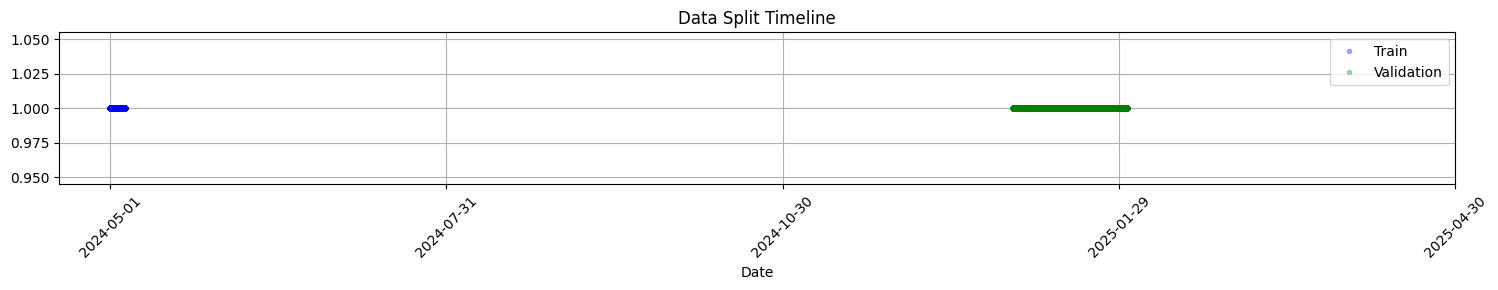

In [17]:
def annualize_factor(sampling: str):
    return ANNUALIZATION.get(sampling, 365*24)

def compute_metrics(equity_curve: pd.Series, sampling: str, turnover_series: pd.Series = None):
    ret = equity_curve.pct_change().dropna()
    ann = annualize_factor(sampling)
    mu = ret.mean() * ann
    sigma = ret.std() * math.sqrt(ann)
    sharpe = mu / (sigma + 1e-12)
    downside = ret[ret < 0].std() * math.sqrt(ann)
    sortino = mu / (downside + 1e-12)
    if len(equity_curve) > 1:
        # Calculate years based on number of samples and sampling frequency
        if isinstance(equity_curve.index, pd.DatetimeIndex):
            dt_years = (equity_curve.index[-1] - equity_curve.index[0]).total_seconds() / (365 * 24 * 3600)
        else:
            # If using RangeIndex, calculate based on sampling frequency
            samples = len(equity_curve)
            samples_per_year = annualize_factor(sampling)
            dt_years = samples / samples_per_year
        dt_years = float(dt_years) if float(dt_years) != 0 else 1e-12
        cagr = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1/dt_years) - 1
    else:
        cagr = 0.0
    cummax = equity_curve.cummax()
    dd = (equity_curve / cummax - 1).min()
    maxdd = float(dd)
    calmar = mu / (abs(maxdd) + 1e-12)
    hit_ratio = (ret > 0).mean()
    turnover = turnover_series.mean() if turnover_series is not None and len(turnover_series)>0 else np.nan
    return {"CAGR": cagr, "Sharpe": sharpe, "Sortino": sortino, "MaxDrawdown": maxdd, "Calmar": calmar, "Volatility": sigma, "Turnover": turnover, "HitRatio": hit_ratio}

def plot_series(series: pd.Series, title: str):
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

def plot_splits(time_index: pd.DatetimeIndex, train_mask: np.ndarray, val_mask: np.ndarray):
    """Plot timeline showing training and validation periods."""
    plt.figure(figsize=(15,3))
    
    # Convert time index to numeric for plotting
    x = np.arange(len(time_index))
    
    # Plot splits
    plt.plot(x[train_mask], [1]*train_mask.sum(), 'b.', label='Train', alpha=0.3)
    plt.plot(x[val_mask], [1]*val_mask.sum(), 'g.', label='Validation', alpha=0.3)
    
    # Set x-axis ticks to show dates
    tick_locations = np.linspace(0, len(time_index)-1, 5, dtype=int)
    plt.xticks(tick_locations, time_index[tick_locations].strftime('%Y-%m-%d'), rotation=45)
    
    plt.title("Data Split Timeline")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def backtest_env(env: gym.Env, model=None, include_leverage: bool = False):
    # Get the unwrapped environment
    unwrapped = env.unwrapped if hasattr(env, 'unwrapped') else env
    
    obs, _ = env.reset()
    pv, turns, levs, actions = [], [], [], []  # Initialize lists for portfolio value, turnover, leverage, and actions
    
    for t in range(len(unwrapped.R)-1):
        if model is None:
            action = np.array([0.0])  # Default to cash position (action=0)
        else:
            action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, trunc, info = env.step(action)
        pv.append(info["portfolio_value"])
        turns.append(info["turnover"])
        levs.append(info["total_leverage"])  # Track leverage from info dict
        actions.append(info.get("action_taken", action[0] if isinstance(action, np.ndarray) else action))  # Track action taken
        if done:
            break
            
    idx = pd.RangeIndex(start=0, stop=len(pv), step=1)
    ec = pd.Series(pv, index=idx)
    to = pd.Series(turns, index=idx)
    lev = pd.Series(levs, index=idx)  # Create leverage Series
    act = pd.Series(actions, index=idx)  # Create actions Series
    
    if include_leverage:
        return ec, to, lev, act
    return ec, to

# Plot data splits
print("Visualizing data splits timeline...")
plot_splits(TIME_INDEX, train_mask, val_mask)

Slicing: 7080 samples out of 2513758 fall in range 2024-05-01 00:00:00+00:00 to 2024-05-04 23:59:00+00:00
Features per asset: 8
Observation dimension: 192
Observation space shape: (192,)
Action space: Continuous Box([-1, 1]) -> Actions range from -1 (short/long) to 1 (long/short)
Slicing: 215384 samples out of 2513758 fall in range 2025-01-01 00:00:00+00:00 to 2025-01-31 23:59:00+00:00
Features per asset: 8
Observation dimension: 192
Observation space shape: (192,)
Action space: Continuous Box([-1, 1]) -> Actions range from -1 (short/long) to 1 (long/short)
Features per asset: 8
Observation dimension: 192
Observation space shape: (192,)
Action space: Continuous Box([-1, 1]) -> Actions range from -1 (short/long) to 1 (long/short)
Slicing: 215384 samples out of 2513758 fall in range 2025-01-01 00:00:00+00:00 to 2025-01-31 23:59:00+00:00
Features per asset: 8
Observation dimension: 192
Observation space shape: (192,)
Action space: Continuous Box([-1, 1]) -> Actions range from -1 (short/lo

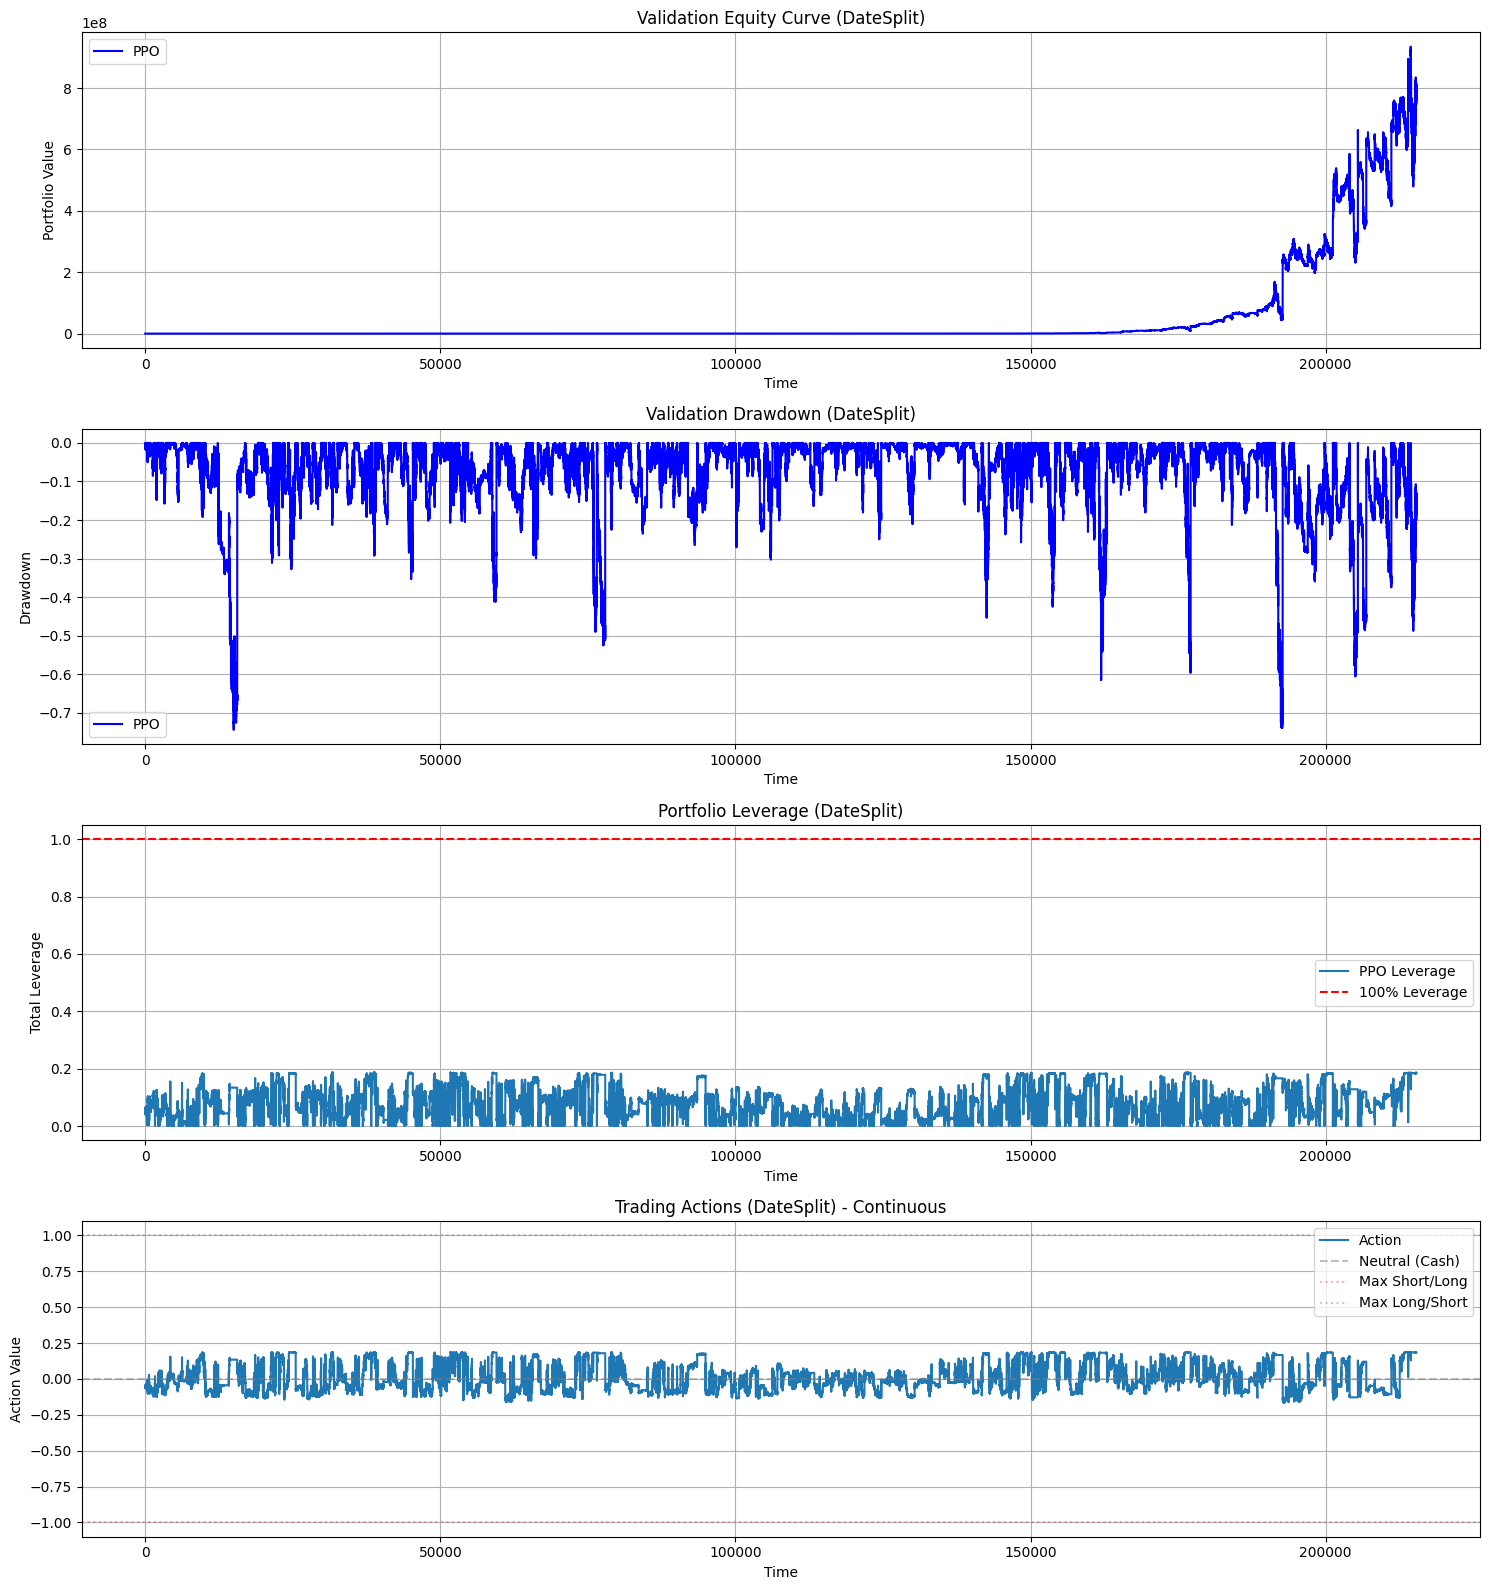

In [18]:
ensure_dir(CONFIG["IO"]["models_dir"])
ensure_dir(CONFIG["EVAL"]["reports_dir"])

# Check if required tensors exist
if 'X_all' not in globals() or 'R_all' not in globals() or 'VOL_all' not in globals() or 'SAMPLE_TIMESTAMPS' not in globals():
    raise NameError(
        "Required tensors (X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS) not found!\n"
        "Please run the tensor construction cell (cell 29) before running this cell.\n"
        "The cell starts with: def build_state_tensor_for_interval..."
    )

RESULTS = []

for split in SPLITS:
    train_env = make_env_from_mask(split["train"], name=f"{split['name']}_train")
    val_env = make_env_from_mask(split["val"], name=f"{split['name']}_val")

    vec_train = DummyVecEnv([lambda: train_env])
    vec_val = DummyVecEnv([lambda: val_env])

    model = PPO(
        policy=CONFIG["RL"]["policy"],
        env=vec_train,
        gamma=CONFIG["RL"]["gamma"],
        gae_lambda=CONFIG["RL"]["gae_lambda"],
        clip_range=CONFIG["RL"]["clip_range"],
        n_steps=CONFIG["RL"]["n_steps"],
        batch_size=CONFIG["RL"]["batch_size"],
        learning_rate=CONFIG["RL"]["learning_rate"],
        ent_coef=CONFIG["RL"]["ent_coef"],
        vf_coef=CONFIG["RL"]["vf_coef"],
        max_grad_norm=CONFIG["RL"]["max_grad_norm"],
        tensorboard_log=CONFIG["IO"]["tb_logdir"],
        device="cpu",
        verbose=0
    )

    eval_callback = EvalCallback(
        vec_val, 
        best_model_save_path=CONFIG["IO"]["models_dir"],
        log_path=CONFIG["IO"]["models_dir"], 
        eval_freq=10000,
        deterministic=True, 
        render=False
    )
    
    model.learn(total_timesteps=CONFIG["RL"]["timesteps"], callback=eval_callback)
    model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{split['name']}.zip")
    model.save(model_path)

    # Run validation
    val_env = make_env_from_mask(split["val"], name=f"{split['name']}_val")
    ec, to, lev, act = backtest_env(val_env, model=model, include_leverage=True)

    # Compare against equal weight strategy on validation set
    base_env = val_env.unwrapped if hasattr(val_env, "unwrapped") else val_env
    raw_returns = np.asarray(base_env.R)
    if raw_returns.ndim == 1:
        raw_returns = raw_returns.reshape(-1, 1)

    steps = min(len(ec.index) - 1, raw_returns.shape[0])
    if raw_returns.shape[1] == 0 or steps <= 0:
        ec_bench = pd.Series(np.ones(len(ec.index)), index=ec.index)
    else:
        ew = np.ones(raw_returns.shape[1]) / raw_returns.shape[1]
        ec_bench = [1.0]
        for i in range(steps):
            step_ret = float(np.dot(ew, raw_returns[i].reshape(-1)))
            ec_bench.append(ec_bench[-1] * math.exp(step_ret))
        if len(ec_bench) < len(ec.index):
            ec_bench.extend([ec_bench[-1]] * (len(ec.index) - len(ec_bench)))
        ec_bench = pd.Series(ec_bench[:len(ec.index)], index=ec.index)


    # Calculate metrics
    m_model = compute_metrics(ec, CONFIG["DATA"]["sampling"], to)
    m_ew = compute_metrics(ec_bench, CONFIG["DATA"]["sampling"])

    # Add average leverage to model metrics
    m_model["Avg_Leverage"] = lev.mean()
    m_model["Max_Leverage"] = lev.max()

    RESULTS.append({
        "split": split["name"], 
        "model": m_model, 
        "equal_weight": m_ew
    })

    if CONFIG["EVAL"]["plots"]:
        plt.figure(figsize=(15, 16))
        
        # Plot equity curves
        plt.subplot(4, 1, 1)
        plt.plot(ec.index, ec.values, label='PPO', color='blue')
        plt.title(f"Validation Equity Curve ({split['name']})")
        plt.xlabel("Time")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid(True)
        
        # Plot drawdowns
        plt.subplot(4, 1, 2)
        plt.plot(ec.index, (ec / ec.cummax()) - 1.0, label='PPO', color='blue')
        plt.title(f"Validation Drawdown ({split['name']})")
        plt.xlabel("Time")
        plt.ylabel("Drawdown")
        plt.legend()
        plt.grid(True)
        
        # Plot leverage
        plt.subplot(4, 1, 3)
        plt.plot(lev.index, lev.values, label='PPO Leverage')
        plt.axhline(y=1.0, color='r', linestyle='--', label='100% Leverage')
        plt.title(f"Portfolio Leverage ({split['name']})")
        plt.xlabel("Time")
        plt.ylabel("Total Leverage")
        plt.legend()
        plt.grid(True)
        
        # Plot actions
        plt.subplot(4, 1, 4)
        plt.plot(act.index, act.values, label='Action', drawstyle='steps-post')
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral (Cash)')
        plt.axhline(y=-1, color='red', linestyle=':', alpha=0.3, label='Max Short/Long')
        plt.axhline(y=1, color='green', linestyle=':', alpha=0.3, label='Max Long/Short')
        plt.ylim(-1.1, 1.1)
        plt.title(f"Trading Actions ({split['name']}) - Continuous")
        plt.xlabel("Time")
        plt.ylabel("Action Value")
        plt.legend()
        plt.grid(True)
        

        plt.tight_layout()
        plt.show()

In [19]:
# Create a DataFrame with all results
rows = []
for res in RESULTS:
    row = {"split": res["split"]}
    for k, metrics in res.items():
        if k == "split":
            continue
        for mname, mval in metrics.items():
            row[f"{k}_{mname}"] = mval
    rows.append(row)

df_results = pd.DataFrame(rows)

# Reorder columns to group related metrics together
column_order = ['split']
for model_type in ['model', 'equal_weight']:
    for metric in ['CAGR', 'Sharpe', 'Sortino', 'Calmar', 'MaxDrawdown', 'Volatility', 'Turnover', 'HitRatio']:
        col = f"{model_type}_{metric}"
        if col in df_results.columns:
            column_order.append(col)
    # Add leverage metrics for model only
    if model_type == 'model':
        for metric in ['Avg_Leverage', 'Max_Leverage']:
            col = f"{model_type}_{metric}"
            if col in df_results.columns:
                column_order.append(col)

df_results = df_results[column_order]

# Format only numeric columns, leave 'split' column as-is
format_dict = {col: "{:.4f}" for col in df_results.columns if col != 'split'}
display(df_results.style.format(format_dict))

,split,model_CAGR,model_Sharpe,model_Sortino,model_Calmar,model_MaxDrawdown,model_Volatility,model_Turnover,model_HitRatio,model_Avg_Leverage,model_Max_Leverage,equal_weight_CAGR,equal_weight_Sharpe,equal_weight_Sortino,equal_weight_Calmar,equal_weight_MaxDrawdown,equal_weight_Volatility,equal_weight_Turnover,equal_weight_HitRatio
0,DateSplit,5395815752932581703680.0000,8.3940,19.1294,103.7118,-0.7441,9.1943,0.0017,0.4998,0.0781,0.1871,33613942216415.8945,1.7041,1347898.1809,77267167.4918,-1.0000,45342014.9927,nan,0.4990


In [20]:
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
ensure_dir(CONFIG["EVAL"]["reports_dir"])
out_json = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.json")
out_csv  = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.csv")
df_results.to_csv(out_csv, index=False)
with open(out_json, "w") as f:
    json.dump(RESULTS, f, indent=2)
print("Saved:", out_json, "and", out_csv)

Saved: ./reports/metrics_20251115_101854.json and ./reports/metrics_20251115_101854.csv


## Inference: Generate Trading Signals

This cell contains a standalone inference function that can be copied to a separate Python script.
The function takes a single observation (features for one timestep) and outputs a trading signal in JSON format.

In [21]:
"""
STANDALONE INFERENCE FUNCTION
==============================
This function can be copied to a separate Python script for production use.
It takes features for a single timestep and generates a trading signal.

Required imports for standalone use:
    import numpy as np
    import pandas as pd
    from datetime import datetime
    from stable_baselines3 import PPO

Feature structure:
------------------
Single asset features (per asset): 12 features
    ['close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow', 
     'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow', 
     'funding', 'fundingMinutesLeft']

Pair features (for both assets combined): 8 features
    ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman', 
     'spreadNormMa', 'spreadNormVol']
"""

def continuous_action_to_weights(action: float) -> tuple[float, float]:
    """
    Convert continuous action [-1, 1] to portfolio weights.
    
    Parameters
    ----------
    action : float
        Action value from -1 (short asset1/long asset2) to 1 (long asset1/short asset2)
    
    Returns
    -------
    tuple[float, float]
        (asset1_weight, asset2_weight)
    """
    action = np.clip(action, -1.0, 1.0)
    position_size = action * 0.5
    asset1_weight = position_size
    asset2_weight = -position_size
    return asset1_weight, asset2_weight


def generate_signal_from_features(
    model_path: str,
    asset1: str,
    asset2: str,
    asset1_features: dict,
    asset2_features: dict,
    pair_features: dict,
    lookback_window: int = 24,
    timestamp: str = None,
    notional_usd: float = 100,
    bar_timeframe: str = "1h",
    exchange: str = "binance_perpetual",
    fresh_for_seconds: int = 3600,
    version: int = 1
) -> dict:
    """
    Generate a trading signal from features for a single timestep.
    
    This is a STANDALONE function that can be copied to a separate Python script.
    
    Parameters
    ----------
    model_path : str
        Path to the trained PPO model (.zip file)
    asset1 : str
        First asset symbol (e.g., "ETH")
    asset2 : str
        Second asset symbol (e.g., "BTC")
    asset1_features : dict
        Features for asset1 with keys:
        ['close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow',
         'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow',
         'funding', 'fundingMinutesLeft']
        Each value should be a list/array of length lookback_window
    asset2_features : dict
        Features for asset2 (same structure as asset1_features)
    pair_features : dict
        Combined pair features with keys:
        ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman',
         'spreadNormMa', 'spreadNormVol']
        Each value should be a list/array of length lookback_window
    lookback_window : int
        Number of historical timesteps (default: 24)
    timestamp : str, optional
        ISO format timestamp. If None, uses current time.
    notional_usd : float
        Notional value in USD
    bar_timeframe : str
        Timeframe of bars (e.g., "1h", "1m")
    exchange : str
        Exchange identifier
    fresh_for_seconds : int
        Signal validity duration in seconds
    version : int
        Signal format version
    
    Returns
    -------
    dict
        Trading signal in JSON format
    
    Example
    -------
    >>> signal = generate_signal_from_features(
    ...     model_path="./models/ppo_model.zip",
    ...     asset1="ETH",
    ...     asset2="BTC",
    ...     asset1_features={
    ...         'close': [0.1, 0.2, ...],  # 24 values
    ...         'closeBias': [0.05, -0.03, ...],
    ...         # ... other 10 features
    ...     },
    ...     asset2_features={
    ...         'close': [0.15, 0.18, ...],
    ...         # ... other 11 features
    ...     },
    ...     pair_features={
    ...         'alpha': [0.01, 0.02, ...],  # 24 values
    ...         'beta': [0.98, 0.99, ...],
    ...         # ... other 6 features
    ...     }
    ... )
    """
    
    # Define feature order (must match training order)
    SINGLE_ASSET_FEATURES = [
        'close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow',
        'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow',
        'funding', 'fundingMinutesLeft'
    ]
    
    PAIR_FEATURES = [
        'alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman',
        'spreadNormMa', 'spreadNormVol'
    ]
    
    # Validate inputs
    for feat in SINGLE_ASSET_FEATURES:
        if feat not in asset1_features:
            raise ValueError(f"Missing feature '{feat}' in asset1_features")
        if feat not in asset2_features:
            raise ValueError(f"Missing feature '{feat}' in asset2_features")
        if len(asset1_features[feat]) != lookback_window:
            raise ValueError(f"asset1_features['{feat}'] must have length {lookback_window}")
        if len(asset2_features[feat]) != lookback_window:
            raise ValueError(f"asset2_features['{feat}'] must have length {lookback_window}")
    
    for feat in PAIR_FEATURES:
        if feat not in pair_features:
            raise ValueError(f"Missing feature '{feat}' in pair_features")
        if len(pair_features[feat]) != lookback_window:
            raise ValueError(f"pair_features['{feat}'] must have length {lookback_window}")
    
    # Build observation tensor
    # Shape: (n_features * lookback_window,) where n_features = 12 + 12 + 8 = 32
    # But we only use pair features for the model since it's pair trading
    # Total features per pair = 8 pair features
    # Observation shape: (8 features * 24 lookback,) = (192,)
    
    n_pair_features = len(PAIR_FEATURES)
    obs = np.zeros((n_pair_features, lookback_window), dtype=np.float32)
    
    # Fill pair features
    for i, feat in enumerate(PAIR_FEATURES):
        obs[i, :] = pair_features[feat]
    
    # Flatten to (n_features * lookback_window,)
    obs = obs.reshape(-1).astype(np.float32)
    
    # Clip observation values (same as training)
    obs = np.clip(obs, -5.0, 5.0)
    
    # Load model and predict
    model = PPO.load(model_path)
    action, _ = model.predict(obs, deterministic=True)
    
    # Convert action to weights
    action_value = float(action[0]) if isinstance(action, np.ndarray) else float(action)
    asset1_weight, asset2_weight = continuous_action_to_weights(action_value)
    
    # Get or generate timestamp
    if timestamp is None:
        timestamp = pd.Timestamp.now(tz='UTC').strftime("%Y-%m-%dT%H:%M:%SZ")
    elif isinstance(timestamp, pd.Timestamp):
        timestamp = timestamp.strftime("%Y-%m-%dT%H:%M:%SZ")
    
    # Create signal JSON
    signal = {
        "timestamp": timestamp,
        "bar_timeframe": bar_timeframe,
        "pair": {
            "asset1": asset1,
            "asset2": asset2
        },
        "markets": {
            "exchange": exchange,
            "asset1": f"{asset1}-USDT",
            "asset2": f"{asset2}-USDT"
        },
        "weights": {
            "asset1": float(asset1_weight),
            "asset2": float(asset2_weight)
        },
        "notional_usd": notional_usd,
        "fresh_for_seconds": fresh_for_seconds,
        "version": version
    }
    
    return signal


# Example usage with the notebook's trained model
print("=" * 80)
print("STANDALONE INFERENCE FUNCTION")
print("=" * 80)
print("\nThe function 'generate_signal_from_features' above can be copied to a")
print("separate Python script for production use.")
print("\nIt requires:")
print("  - A trained PPO model (.zip file)")
print("  - Features for a single timestep:")
print("    * asset1_features: 12 features x lookback_window values")
print("    * asset2_features: 12 features x lookback_window values")
print("    * pair_features: 8 features x lookback_window values")
print("\nExample below demonstrates usage with validation data...")
print("=" * 80)

STANDALONE INFERENCE FUNCTION

The function 'generate_signal_from_features' above can be copied to a
separate Python script for production use.

It requires:
  - A trained PPO model (.zip file)
  - Features for a single timestep:
    * asset1_features: 12 features x lookback_window values
    * asset2_features: 12 features x lookback_window values
    * pair_features: 8 features x lookback_window values

Example below demonstrates usage with validation data...


In [22]:
# Demo: Test the standalone function with validation data
print("\nRunning demo with validation data...\n")

# Load the trained model
best_split = SPLITS[0]
model_path = os.path.join(CONFIG["IO"]["models_dir"], f"ppo_{best_split['name']}.zip")

if os.path.exists(model_path):
    # Get a sample from validation data
    val_env_test = make_env_from_mask(best_split["val"], name="test_val")
    unwrapped_env = val_env_test.unwrapped if hasattr(val_env_test, 'unwrapped') else val_env_test
    
    # Get the first pair
    sample_pair = all_pairs[0]
    asset1, asset2 = sample_pair
    
    # Extract features from the first timestep in validation
    # Shape of X: (samples, 1, n_features, lookback)
    sample_idx = 0
    sample_features = unwrapped_env.X[sample_idx, 0, :, :]  # (n_features, lookback)
    
    # For demo, we'll construct the feature dictionaries
    # Note: In production, you'd receive these features from your data pipeline
    lookback = CONFIG["ENV"]["lookback_window"]
    
    # Define feature names
    PAIR_FEATURES = [
        'alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman',
        'spreadNormMa', 'spreadNormVol'
    ]
    
    # Build pair_features dict from the sample
    pair_features = {}
    for i, feat_name in enumerate(PAIR_FEATURES):
        if i < sample_features.shape[0]:
            pair_features[feat_name] = sample_features[i, :].tolist()
    
    # For single asset features, we'll use dummy data since the model only uses pair features
    SINGLE_ASSET_FEATURES = [
        'close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow',
        'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow',
        'funding', 'fundingMinutesLeft'
    ]
    
    asset1_features = {feat: [0.0] * lookback for feat in SINGLE_ASSET_FEATURES}
    asset2_features = {feat: [0.0] * lookback for feat in SINGLE_ASSET_FEATURES}
    
    # Get timestamp
    val_timestamps = SAMPLE_TIMESTAMPS[SAMPLE_TIMESTAMPS >= pd.Timestamp(CONFIG["SPLITS"]["val"][0], tz='UTC')]
    if len(val_timestamps) > 0:
        sample_timestamp = val_timestamps[0]
    else:
        sample_timestamp = None
    
    # Generate signal using standalone function
    try:
        signal = generate_signal_from_features(
            model_path=model_path,
            asset1=asset1,
            asset2=asset2,
            asset1_features=asset1_features,
            asset2_features=asset2_features,
            pair_features=pair_features,
            lookback_window=lookback,
            timestamp=sample_timestamp,
            notional_usd=100,
            bar_timeframe="1h",
            exchange="binance_perpetual",
            fresh_for_seconds=3600,
            version=1
        )
        
        print("✓ Successfully generated signal using standalone function!\n")
        print("Sample output:")
        print(json.dumps(signal, indent=2))
        
        # Save as example
        example_file = os.path.join(CONFIG["EVAL"]["reports_dir"], "signal_example.json")
        with open(example_file, "w") as f:
            json.dump(signal, f, indent=2)
        print(f"\n✓ Saved example signal to: {example_file}")
        
    except Exception as e:
        print(f"✗ Error generating signal: {str(e)}")
        import traceback
        traceback.print_exc()
    
else:
    print(f"✗ Model not found at {model_path}")
    print("Please run the training cell first.")


Running demo with validation data...

Slicing: 215384 samples out of 2513758 fall in range 2025-01-01 00:00:00+00:00 to 2025-01-31 23:59:00+00:00
Features per asset: 8
Observation dimension: 192
Observation space shape: (192,)
Action space: Continuous Box([-1, 1]) -> Actions range from -1 (short/long) to 1 (long/short)
✓ Successfully generated signal using standalone function!

Sample output:
{
  "timestamp": "2025-01-24T00:24:00Z",
  "bar_timeframe": "1h",
  "pair": {
    "asset1": "AAVE",
    "asset2": "SUI"
  },
  "markets": {
    "exchange": "binance_perpetual",
    "asset1": "AAVE-USDT",
    "asset2": "SUI-USDT"
  },
  "weights": {
    "asset1": -0.031448960304260254,
    "asset2": 0.031448960304260254
  },
  "notional_usd": 100,
  "fresh_for_seconds": 3600,
  "version": 1
}

✓ Saved example signal to: ./reports/signal_example.json
